In [0]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

from collections import defaultdict

matplotlib.style.use('ggplot')

In [0]:
#@title
import numpy as np
import sys
from gym.envs.toy_text import discrete


UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class CliffWalkingEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta):
        new_position = np.array(current) + np.array(delta)
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        reward = -100.0 if self._cliff[tuple(new_position)] else -1.0
        is_done = self._cliff[tuple(new_position)] or (tuple(new_position) == (3,11))
        return [(1.0, new_state, reward, is_done)]

    def __init__(self):
        self.shape = (4, 12)

        nS = np.prod(self.shape)
        nA = 4

        # Cliff Location
        self._cliff = np.zeros(self.shape, dtype=np.bool)
        self._cliff[3, 1:-1] = True

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0])
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1])
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0])
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1])

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0

        super(CliffWalkingEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            # print(self.s)
            if self.s == s:
                output = " x "
            elif position == (3,11):
                output = " T "
            elif self._cliff[position]:
                output = " C "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip() 
            if position[1] == self.shape[1] - 1:
                output = output.rstrip() 
                output += "\n"

            outfile.write(output)
        outfile.write("\n")

In [0]:
#@title
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [0]:
env = CliffWalkingEnv()

In [0]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
  """
  Q function과 epsilon에 기반으로 epsilon-greedy policy를 생성하는 함수

  Arguments:
  Q: (state -> action-value)의 dictionary
  nA 길이의 numpy array

  nA: 환경에서 action의 개수
  """
  def policy_fn(observation):
    A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[observation])
    A[best_action] += (1.0 - epsilon)
    return A
  return policy_fn

In [0]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
  """
  Q-Learning 알고리즘: 비활성 정책 TD 제어.
  epsilon-greedy 정책을 따르는 동안에 최적의 greedy 정책을 찾음

  Arguments:
  env: OpenAI환경
  num_episodes: 실행하는 에피소드의 수
  discount_factor: Gamma 값
  alpha: TD learning rate
  epsilon: random action 할 비율

  Returns:
  (Q, episode_lengths)
  Q: 최적 action-value function (dictionary(state -> action value))
  """
  # 최종 action-value function
  Q = defaultdict(lambda: np.zeros(env.action_space.n))

  stats = EpisodeStats(
      episode_lengths=np.zeros(num_episodes),
      episode_rewards=np.zeros(num_episodes),
  )

  policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

  for i_episode in range(num_episodes):
    if (i_episode + 1) % 100 == 0:
      print(f"\rEpisode {i_episode+1}/{num_episodes}.", end="")
      sys.stdout.flush()
    
    # reset environment and pick first action
    state = env.reset()

    for t in itertools.count():
      # Step 한단계
      action_probs = policy(state)
      action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
      next_state, reward, done, _ = env.step(action)

      # update statistics
      stats. episode_rewards[i_episode] += reward
      stats.episode_lengths[i_episode] = t

      # TD update
      best_next_action = np.argmax(Q[next_state])
      td_target = reward + discount_factor * Q[next_state][best_next_action]
      td_delta = td_target - Q[state][action]
      Q[state][action] += alpha * td_delta

      if done:
        break

      state = next_state

  return Q, stats


In [8]:
Q, stats = q_learning(env, 500)

Episode 500/500.

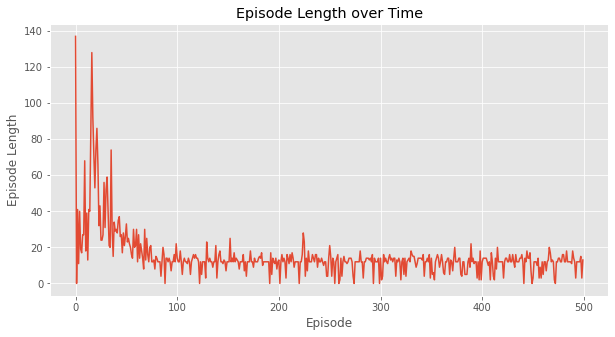

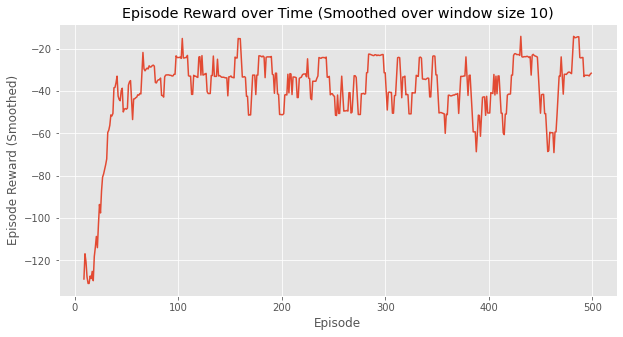

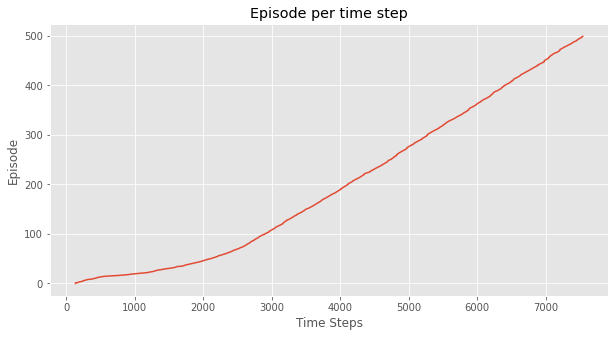

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [9]:
plot_episode_stats(stats)